In [91]:
import apimoex
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Скачиваем цены на акции

C:\Users\Ваня\AppData\Local\Temp\ipykernel_19112\3088111547.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  presence_map = presence_map.applymap(lambda x: 1 if x > 0 else 0)


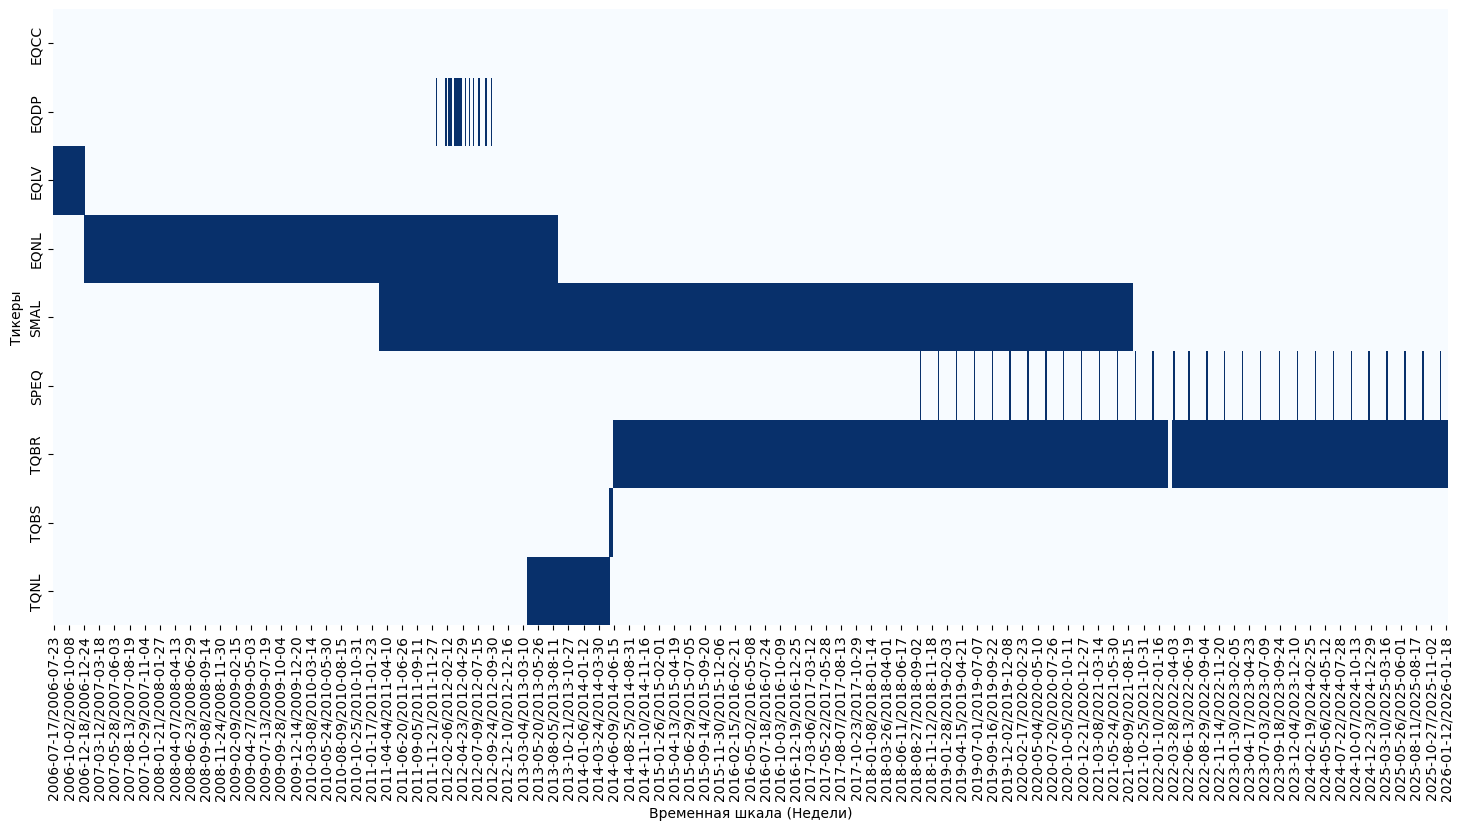

In [ ]:
df = pd.read_csv('../data/1-raw/sentiment.csv')
df['time'] = pd.to_datetime(df['date'])
start_date, end_date = min(df['date']), max(df['date'])

def get_history(company_name="ROSN"):
    with requests.Session() as session:
        # Указываем тикер, рынок (shares) и режим торгов (tqbr)
        data = apimoex.get_market_history(
            session, 
            company_name, 
            start=start_date, 
            end=end_date,
        )
        prices = pd.DataFrame(data)
        prices['TRADEDATE'] = pd.to_datetime(prices['TRADEDATE'])
        return prices


prices = get_history()
presence_map = prices.pivot_table(index='BOARDID', 
                              columns=pd.to_datetime(prices['TRADEDATE']).dt.to_period('W'), 
                              values='CLOSE', # любой числовой столбец
                              aggfunc='count').fillna(0)

presence_map = presence_map.applymap(lambda x: 1 if x > 0 else 0)
plt.figure(figsize=(18, 8))
sns.heatmap(presence_map, cmap="Blues", cbar=False, yticklabels=True)
plt.xlabel('Временная шкала (Недели)')
plt.ylabel('Тикеры')
plt.show()

In [93]:
tqbr_start = prices[prices['BOARDID'] == 'TQBR']['TRADEDATE'].min()

part1 = prices[(prices['BOARDID'] == 'EQBR') & (prices['TRADEDATE'] <= tqbr_start)]
part2 = prices[(prices['BOARDID'] == 'TQBR') & (prices['TRADEDATE'] > tqbr_start)]

final_df = pd.concat([part1, part2]).sort_values('TRADEDATE')
prices = final_df
prices = prices.drop('BOARDID', axis=1)
prices.rename(columns={'TRADEDATE': 'date', 'CLOSE': 'close', 'VOLUME': 'volume', 'VALUE': 'value'}, inplace=True)

Аггрегируем исходный столбец по дням

In [94]:
df['date'] = pd.to_datetime(df['date'])
df_aggregated = df.groupby(df['date'].dt.date)['sentiment'].value_counts().unstack(fill_value=0)
df_aggregated['views'] = df.groupby(df['date'].dt.date)['views'].aggregate("sum")
df_aggregated['sentiment_score'] = (df_aggregated['positive'] - df_aggregated['negative']) / (df_aggregated['positive'] + df_aggregated['negative'] + 0.1 * df_aggregated['neutral'])
df_aggregated = df_aggregated.reset_index()
df_aggregated['date'] = pd.to_datetime(df_aggregated['date'])

In [95]:
merged = pd.merge(df_aggregated, prices, how='left', on='date')

In [96]:
groups = merged['close'].notna()[::-1].cumsum()[::-1]
cols_to_fix = ["sentiment_score", "views", "negative", "neutral", "positive"]
merged[cols_to_fix] = merged.groupby(groups)[cols_to_fix].transform('sum')
merged.dropna(inplace=True)

Создание дополнительных признаков

In [ ]:
merged['return'] = (merged['close'] - merged['close'].shift(1)) / merged['close']
merged.dropna(inplace=True)
merged['rolling_mean_7'] = merged['return'].rolling(7).mean()
merged['rolling_mean_14'] = merged['return'].rolling(14).mean()
merged['rolling_std_7'] = merged['return'].rolling(7).std()
merged['rolling_std_14'] = merged['return'].rolling(14).std()

# merged['rolling_mean_7'] = merged['rolling_mean_7'].fillna(merged['close'])
# merged['rolling_mean_14'] = merged['rolling_mean_14'].fillna(merged['close'])
# merged['rolling_std_7'] = merged['close'].fillna(1)
# merged['rolling_std_14'] = merged['close'].fillna(1)

merged.dropna(inplace=True)

merged['day'] = merged['date'].dt.day
merged['month'] = merged['date'].dt.month
merged['year'] = merged['date'].dt.year

In [98]:
processed = merged.drop(columns=['date', 'negative', 'positive', 'value', 'neutral'])
processed.to_csv('../data/2-processed/processed.csv', index=False)

Проведем анализ важности и посмотрим, что еще можно выкинуть

In [99]:
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import MinMaxScaler

features = [
    'sentiment_score', 'volume',  
    'day', 'month', 
]

merged = pd.read_csv('../data/2-processed/processed.csv')

n = int(len(merged) * 0.8)
X = merged[features].iloc[n:]
y = merged['return'].iloc[n:]

scaler = MinMaxScaler()
scaler.fit(X, y)
X_sc = scaler.transform(X)

model = XGBRegressor()
model.fit(X, y)

plot_importance(model, importance_type='gain', max_num_features=10)
plt.plot()
importance_scores = model.get_booster().get_score(importance_type='gain')

In [100]:
merged['close'].rolling(7).std()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
2890    3.563873
2891    4.065681
2892    3.601207
2893    3.571731
2894    3.499813
Name: close, Length: 2895, dtype: float64

<Axes: >

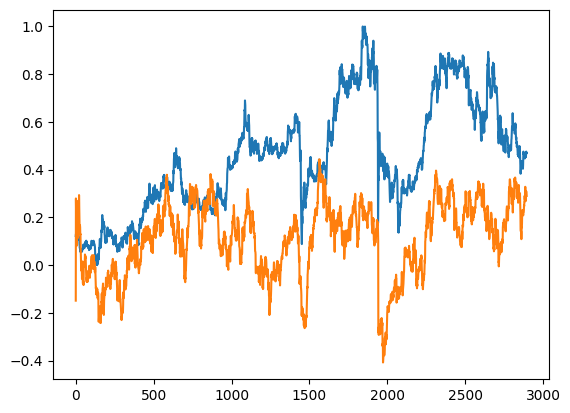

In [101]:
((merged['close'] - merged['close'].min()) / (merged['close'].max() - merged['close'].min())).plot()
merged['sentiment_score'].ewm(alpha=0.05).mean().plot()

In [102]:
processed

views  sentiment_score   close      volume    return  rolling_mean_7  \
3060   416749        -0.148883  249.66  12959310.0  0.027477             NaN   
3065  1682236         0.686306  253.30  19174760.0  0.014370             NaN   
3066   304711         0.045045  251.59   7504200.0 -0.006797             NaN   
3067   163981         0.108696  250.87   7890720.0 -0.002870             NaN   
3068   440756        -0.035088  249.89   8963490.0 -0.003922             NaN   
...       ...              ...     ...         ...       ...             ...   
7260   306503         0.944193  409.65   3688415.0  0.018064        0.003261   
7261    70523         0.432692  413.00   3507863.0  0.008111        0.000935   
7262   129196         0.244898  411.45   2995120.0 -0.003767        0.002879   
7263   152050         0.094340  409.25   5504714.0 -0.005376        0.000343   
7264    29286         0.181818  410.00   6089994.0  0.001829        0.000762   

      rolling_mean_14  rolling_std_7  rolling_std_14  day  month  year  
3060              NaN            NaN             NaN   11      6  2014  
3065              NaN            NaN             NaN   16      6  2014  
3066              NaN            NaN             NaN   17      6  2014  
3067              NaN            NaN             NaN   18      6  2014  
3068              NaN            NaN             NaN   19      6  2014  
...               ...            ...             ...  ...    ...   ...  
7260        -0.000189       0.018008        0.014195   15     12  2025  
7261         0.000881       0.015732        0.014217   16     12  2025  
7262         0.001806       0.013818        0.013380   17     12  2025  
7263         0.000664       0.013407        0.013252   18     12  2025  
7264         0.000566       0.013400        0.013237   19     12  2025  

[2895 rows x 12 columns]

In [103]:
df

Unnamed: 0.1  Unnamed: 0  \
0                  0           0   
1                  1           1   
2                  2           2   
3                  3           3   
4                  4           4   
...              ...         ...   
269252        269252      269252   
269253        269253      269253   
269254        269254      269254   
269255        269255      269255   
269256        269256      269256   

                                                     text                date  \
0       Вступает в силу закон о госрегулировании оборо... 2006-01-01 02:20:00   
1       Украина отказывается от последних предложений ... 2006-01-01 02:38:00   
2       Отменяется лицензирование 50 видов предпринима... 2006-01-01 02:48:00   
3       С 1 января в Москве подорожает проезд в общест... 2006-01-01 02:55:00   
4       В России вступает в силу закон об особых эконо... 2006-01-01 03:08:00   
...                                                   ...                 ...   
269252  Москва пригласила африканских партнеров осваив... 2025-12-20 14:27:00   
269253  Россия готова предложить Африке разработки в э... 2025-12-20 16:05:00   
269254  Ботсвана намерена использовать опыт России в м... 2025-12-20 16:07:00   
269255  В Ботсване предложили российским компаниям уча... 2025-12-20 16:26:00   
269256      Россия поставила рекордную сумму золота Китаю 2025-12-20 18:05:00   

        views                                           tag_text  \
0          36                                                 []   
1          89        ['Газпром повысил цены на газ для Украины']   
2          18                                                 []   
3          23                                                 []   
4          34                                                 []   
...       ...                                                ...   
269252    893  ['Африка', 'Сахара', 'Россия', 'Сергей Лавров'...   
269253    265              ['Россия', 'Сергей Лавров', 'Африка']   
269254    137  ['Ботсвана', 'Россия', 'Каир (город)', 'Сергей...   
269255     89  ['Ботсвана', 'Африка', 'Каир (город)', 'Сергей...   
269256   9296                                ['Китай', 'Россия']   

                                                     href sentiment  \
0                                                      []   neutral   
1             ['/Gazprom_Ukraine_gas_price_rise_141205/']  negative   
2                                                      []   neutral   
3                                                      []   neutral   
4                                                      []   neutral   
...                                                   ...       ...   
269252  ['/location_Africa/', '/location_Sahara/', '/l...   neutral   
269253  ['/location_rossiyskaya-federatsiya/', '/perso...  positive   
269254  ['/location_Botswana/', '/location_rossiyskaya...   neutral   
269255  ['/location_Botswana/', '/location_Africa/', '...   neutral   
269256  ['/location_China/', '/location_rossiyskaya-fe...  positive   

        sentiment_score                time  
0              0.690854 2006-01-01 02:20:00  
1              0.909901 2006-01-01 02:38:00  
2              0.815255 2006-01-01 02:48:00  
3              0.513187 2006-01-01 02:55:00  
4              0.798563 2006-01-01 03:08:00  
...                 ...                 ...  
269252         0.764056 2025-12-20 14:27:00  
269253         0.681224 2025-12-20 16:05:00  
269254         0.869170 2025-12-20 16:07:00  
269255         0.879207 2025-12-20 16:26:00  
269256         0.937926 2025-12-20 18:05:00  

[269257 rows x 10 columns]